 # Assignment 3: Correlation Analysis and Bootstrapping

 ## Objective

 The field of statistics is divided into two major parts: descriptive and inferential. In this assignment, we will cover two important topics in statistics: correlation analysis and bootstrapping, where the former belongs to the descriptive part and the latter belongs to the inferential part. After this assignment, you will be able to answer the following questions:



 1. How to visualize the relationship between two variables?

 2. What is Pearson's correlation? How to compute it?

 3. What is Spearman's rank correlation? How to compute it?

 4. What's the difference between Pearson's correlation and Spearman's rank correlation?

 5. How to estimate a population parameter based on a sample?

 6. How to use the bootstrap to quantify the uncertainty of an estimated value?



 **Requirements:**

 * Use [pandas](https://pandas.pydata.org/) to manipulate data.

 * Use [matplotlib](https://matplotlib.org/) or [seaborn](https://seaborn.pydata.org) to make plots.

 * Please pay attention to visualization principles.





 The data should be part of the downloaded [A3.zip](https://coursys.sfu.ca/2025sp-cmpt-733-g1/pages/A3).



 ## Part 1. Correlation Analysis

 As a data scientist, you often face this kind of question: "Are A and B correlated?" For example,



 * Do Canadian Currency and Oil Price move together?

 * Do Vancouver Housing Price and US Stock Market have any correlation?

 * Are GPA and Gender independent?



 To answer these questions, you need to conduct a correlation analysis.



 Imagine you are a data scientist working at a real-estate company. You could have downloaded the property_tax_report from this [webpage](https://opendata.vancouver.ca/explore/dataset/property-tax-report/table/?refine.report_year=2023). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2023.



 You may think that for a newly built house, it tends to have a higher price than the ones built decades ago. In this assignment, your first job is to figure out whether YEAR_BUILT and HOUSE_PRICE are correlated.

 We first load the data as a DataFrame.

In [1]:
import pandas as pd

df = pd.read_csv("property-tax-report_2023.zip", compression='zip', header=0, sep=';', quotechar='"')


In [2]:
df['HOUSE_PRICE'] = df.apply(lambda x: (x['CURRENT_LAND_VALUE'] \
                                        +x['CURRENT_IMPROVEMENT_VALUE'])/1000000.0, axis = 1)

 ### Task A. Visualizations

 Since the housing price varies a lot by locations, we will only consider the houses whose postcode starts with 'V6A'. Furthermore, we remove the houses that were built before 1900.

 In the following, please make two subplots in one row. For the left subplot, it is a scatter plot with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`; for the right subplot, it is a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`.

Text(0.5, 1.0, 'House Prices Over Time')

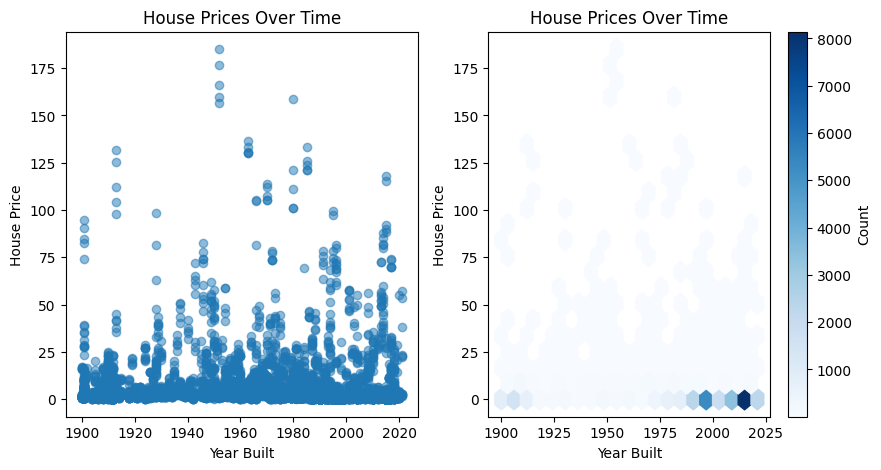

In [3]:
from matplotlib import pyplot as plt
#<-- Write Your Code -->
# drop rows with NaN values in PROPERTY_POSTAL_CODE and YEAR_BUILT
df = df.dropna(subset=['PROPERTY_POSTAL_CODE', 'YEAR_BUILT', 'HOUSE_PRICE'])

# filter postcode by V6A and remove houses built before 1900
df = df[df['PROPERTY_POSTAL_CODE'].str.startswith('V6A')]
df = df[df['YEAR_BUILT'] >= 1900]

plt.figure(figsize=(10, 5))
# add transparency on the scatterplot
plt.subplot(1, 2, 1)
plt.scatter(df['YEAR_BUILT'], df['HOUSE_PRICE'], alpha=0.5)
plt.xlabel('Year Built')
plt.ylabel('House Price')
plt.title('House Prices Over Time')

#  make a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE.
plt.subplot(1, 2, 2)
hb = plt.hexbin(df['YEAR_BUILT'], df['HOUSE_PRICE'], gridsize=20, cmap='Blues', mincnt=1)
plt.xlabel('Year Built')
plt.ylabel('House Price')
plt.colorbar(hb, label='Count')
plt.title('House Prices Over Time')

 Please write down the **two** most interesting findings that you draw from the plot.



 **Findings**

 1. It seems that the most expensive houses in the entire dataset were built around 1955, which is quite old.

 2. There is no clear trend on house prices. I wouldn've imagined the newer ones would've been more expensive.

 The above plots provide a general impression of the relationship between variables. There are some other visualizations that can provide more insights. One option is to bin one variable and plot percentiles of the other.





 In the following, please make three subplots in a row, where each subplot is a scatter plot with X = YEAR_BUILT and Y = HOUSE_PRICE.

 * The first subplot shows how the 25th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `25TH_HOUSE_PRICE`);

 * The second subplot shows how the 50th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `50TH_HOUSE_PRICE`);

 * The third subplot shows how the 75th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `75TH_HOUSE_PRICE`);



Text(0.5, 1.0, '75th Percentile of House Price Over Years')

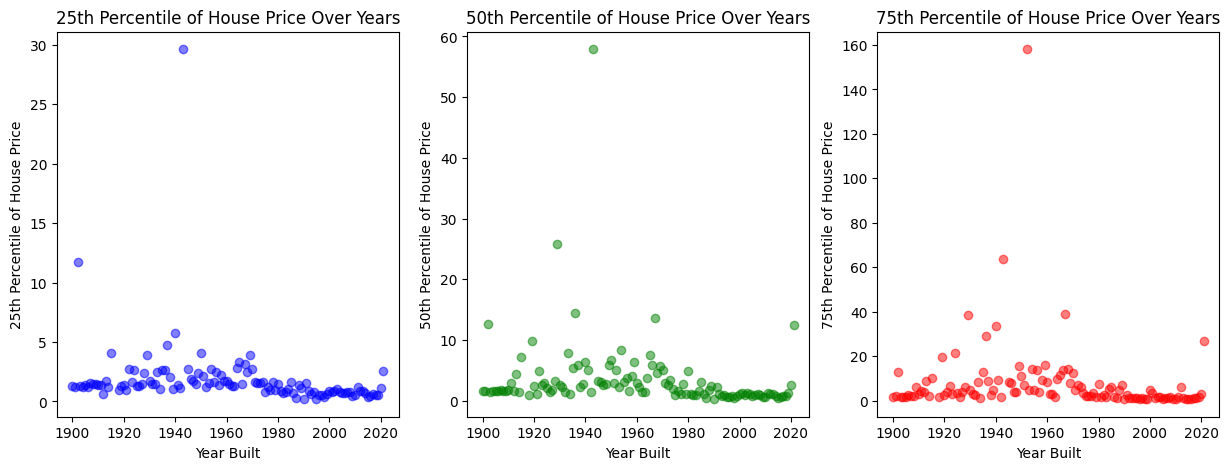

In [4]:
#<-- Write Your Code -->
percentiles = df.groupby('YEAR_BUILT')['HOUSE_PRICE'].quantile([0.25, 0.5, 0.75]).unstack()
years = percentiles.index
percentile_25 = percentiles[0.25]
percentile_50 = percentiles[0.5]
percentile_75 = percentiles[0.75]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(years, percentile_25, color='blue', alpha=0.5)
plt.xlabel('Year Built')
plt.ylabel('25th Percentile of House Price')
plt.title('25th Percentile of House Price Over Years')

plt.subplot(1, 3, 2)
plt.scatter(years, percentile_50, color='green', alpha=0.5)
plt.xlabel('Year Built')
plt.ylabel('50th Percentile of House Price')
plt.title('50th Percentile of House Price Over Years')

plt.subplot(1, 3, 3)
plt.scatter(years, percentile_75, color='red', alpha=0.5)
plt.xlabel('Year Built')
plt.ylabel('75th Percentile of House Price')
plt.title('75th Percentile of House Price Over Years')

 Please write down the **two** most interesting findings that you draw from the plot.



 **Findings**

 1. All of the plots appear to have a very similar distribution in terms of the shape itself.

 2. Around roughly 1950, it seems that the house prices are the most expensive.

 ### Task B. Correlation Coefficient

 A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between a pair of variables.



 In the following, please implement `calc_pearson()` and `calc_spearman()`, respectively. Note that you are *NOT* allowed to use [corr](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) from Pandas or [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr)/[spearmanr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr) from scipy.stats to do this task. In other words, you need to implement the actual algorithms for pearson and spearman.

In [5]:
import numpy as np
from scipy.stats import rankdata

def calc_pearson(df, x, y):
    #<-- Write Your Code --> 
    # x = years
    # y = percentile_25
    x = np.array(x)
    y = np.array(y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    numerator = np.sum((x - mean_x) * (y - mean_y))
    denominator = np.sqrt(np.sum((x - mean_x) ** 2) * np.sum((y - mean_y) ** 2))
    return numerator / denominator

def calc_spearman(df, x, y):
    #<-- Write Your Code -->
    rank_x = rankdata(x)
    rank_y = rankdata(y)
    d = rank_x - rank_y
    numerator = 6 * np.sum(d ** 2)
    denominator = len(x) * (len(x) ** 2 - 1)
    return 1 - (numerator / denominator)

 Then, you can use these two functions to compute the Pearson's correlation as well as Spearman's rank correlation for three pairs of variables: <`25TH_HOUSE_PRICE`, `YEAR_BUILT`>, <`50TH_HOUSE_PRICE`, `YEAR_BUILT`>, and <`75TH_HOUSE_PRICE`, `YEAR_BUILT`>.

In [6]:
for TH, percentile in zip(["25TH", "50TH", "75TH"], [percentile_25, percentile_50, percentile_75]):
  print(f"{TH}_HOUSE_PRICE\t pearson={calc_pearson(df, years, percentile):.6f}\t spearman={calc_spearman(df, years, percentile):.6f}")


25TH_HOUSE_PRICE	 pearson=-0.219988	 spearman=-0.534931
50TH_HOUSE_PRICE	 pearson=-0.186158	 spearman=-0.493178
75TH_HOUSE_PRICE	 pearson=-0.126402	 spearman=-0.426606


 Please write down the **two** most interesting findings that you draw from the result.





 **Findings**

 1. The Pearson coefficient is close to zero, indicating that there is a weak relationship between the housing price and year

 2. The Spearman coefficients are more negative than their corresponding Pearson coefficients, meaning that house prices are slowly decreasing, but not in a linear way, but rather a monotonic way.

 ## Part 2. Bootstrapping

 In reality, it is more often than not that you can only collect a sample of the data. Whenever you derive a conclusion from a sample (e.g., Vancouver's housing price has increased by 10% since last year), you should ALWAYS ask yourself: **"CAN I TRUST IT?"**. In other words, you want to know that if the same analysis was conducted on the full data, would the same conclusion be derived? In Part 2, you will learn how to use bootstrapping to answer this question.

In [7]:
df_sample = pd.read_csv("property-tax-report_2023.zip", compression='zip', header=0, sep=';', quotechar='"')

df_sample['CURRENT_PRICE'] = df_sample.apply(lambda x: x['CURRENT_LAND_VALUE'] \
                                             +x['CURRENT_IMPROVEMENT_VALUE'], axis = 1)

df_sample['PREVIOUS_PRICE'] = df_sample.apply(lambda x: x['PREVIOUS_LAND_VALUE'] \
                                              +x['PREVIOUS_IMPROVEMENT_VALUE'], axis = 1)

df_sample = df_sample[df_sample['LEGAL_TYPE'] == 'STRATA']


 ### Task 1. Analysis Result Without Bootstrapping

 Please compute the median of PREVIOUS_PRICE and CURRENT_PRICE, respectively, and compare them in a bar chart.

Text(0.5, 1.0, 'Median Prices')

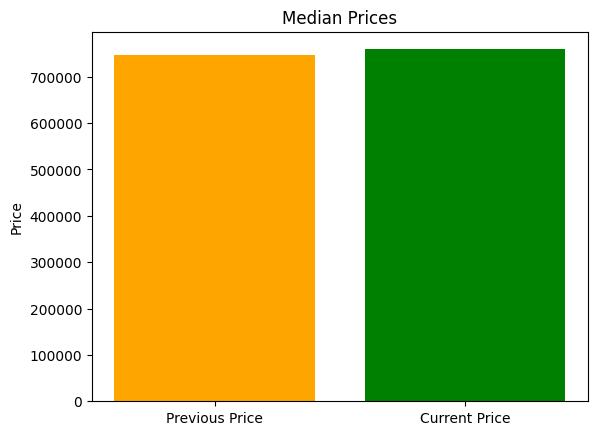

In [8]:
# --- Write your code below ---
df_sample = df_sample.dropna(subset=['CURRENT_PRICE', 'PREVIOUS_PRICE'])

median_previous_price = df_sample['PREVIOUS_PRICE'].median()
median_current_price = df_sample['CURRENT_PRICE'].median()

plt.bar(['Previous Price', 'Current Price'], [median_previous_price, median_current_price], color=['orange', 'green'])
plt.ylabel('Price')
plt.title('Median Prices')

 ### Task 2. Analysis Result With Bootstrapping

From the chart above, we observe the medians of `PREVIOUS_PRICE` and `CURRENT_PRICE`. However, these medians were calculated from a sample, leading to the critical question: **"CAN WE TRUST THESE NUMBERS?"**

To address this, implement the bootstrap method to estimate 95% confidence intervals for each median. Use a **random subset of 10,000 observations** from the dataset as your sample for bootstrapping. This limitation reflects real-world scenarios where only a portion of the data is available for analysis. 

Refer to ["Bootstrap confidence intervals"](https://math.mit.edu/~dav/05.dir/class24-prep-a.pdf) by Jeremy Orloff and Jonathan Bloom for guidance. Section 7 provides a detailed explanation of the algorithm. Once the bootstrap is implemented, add the confidence intervals to the bar chart.

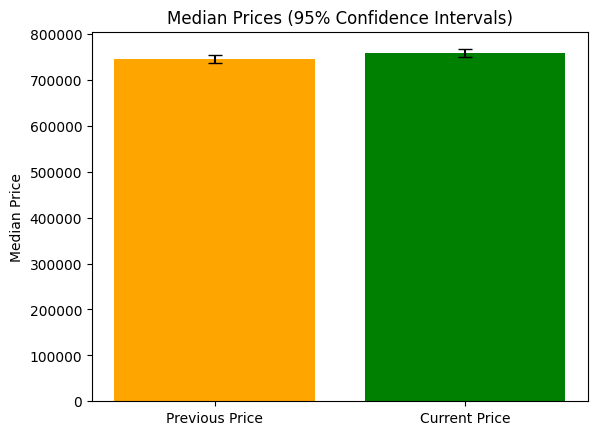

In [9]:
# --- Write your code below ---
n_bootstraps = 1000

previous_price_medians = []
current_price_medians = []

for i in range(n_bootstraps):
    bootstrap_sample = df_sample.sample(n=10000, replace=True)

    previous_price_medians.append(bootstrap_sample['PREVIOUS_PRICE'].median())
    current_price_medians.append(bootstrap_sample['CURRENT_PRICE'].median())

previous_price_medians = np.array(previous_price_medians)
current_price_medians = np.array(current_price_medians)
previous_price_ci = np.percentile(previous_price_medians, [2.5, 97.5])
current_price_ci = np.percentile(current_price_medians, [2.5, 97.5])

categories = ['Previous Price', 'Current Price']
medians = [df_sample['PREVIOUS_PRICE'].median(), df_sample['CURRENT_PRICE'].median()]
lower_bounds = [medians[0] - previous_price_ci[0], medians[1] - current_price_ci[0]]
upper_bounds = [previous_price_ci[1] - medians[0], current_price_ci[1] - medians[1]]

plt.bar(categories, medians, yerr=[lower_bounds, upper_bounds], capsize=5, color=['orange', 'green'])
plt.ylabel('Median Price')
plt.title('Median Prices (95% Confidence Intervals)')
plt.show()



 ## Submission

 Complete the code in this notebook, and submit it to the CourSys activity Assignment 3.